# Perceptron Algorithm 
### Music Genre Classification

In this notebook, we will use the **Perceptron** algorithm to classify music genres.

## Steps:
1. **Preprocessing** the data: We will normalize and select relevant features.
2. **Training the Perceptron**: The Perceptron will learn from the training data.
3. **Evaluating the Model**: We will assess the model's accuracy.



# **Perceptron for Music Genre Classification**

In this section, we will train a **Perceptron model** to classify music genres based on features like **tempo**, **loudness**, and **danceability**. We will focus on the classification of two genres: **pop** and **rock** in the first case, and **rock** and **acoustic** in the second case.

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## 2. Load the Music Dataset

Next, we load the music dataset and filter it to keep only the tracks that belong to **pop**, **rock**, or **acoustic** genres.


In [85]:
# Load the dataset
# 1) Load & clean
df = pd.read_csv('spotify_dataset.csv')

# Keep only rows with all seven core features + genre
features = [
    'danceability','energy','loudness',
    'tempo','valence','acousticness','speechiness'
]
df = df.dropna(subset=features + ['track_genre'])

counts = df['track_genre'].value_counts()
print(counts)

# Check the first few rows of the filtered dataset
df.head()

acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: track_genre, Length: 114, dtype: int64


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## 3. Data Preprocessing

We will now:
- Select the relevant features (e.g., `danceability`, `loudness`, `tempo`).
- Convert the genre labels (`pop`, `rock`, `acoustic`) into numeric values.
- Normalize the feature values for better performance of the Perceptron model.

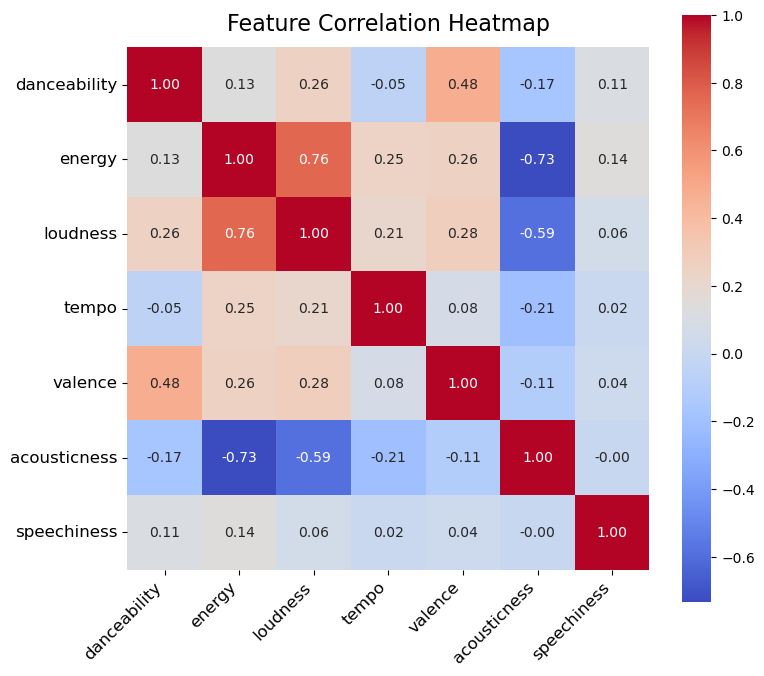

In [86]:

# 2) Heatmap
corr_matrix = df[features].corr()
plt.figure(figsize=(8,8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    square=True,
    cbar_kws={'shrink':0.8}
)
plt.title("Feature Correlation Heatmap", pad=12, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


## 4. Implementing the Perceptron Class

Here, we implement the Perceptron algorithm, which includes methods for training the model and making predictions.

In [87]:
class Perceptron:
    def __init__(self, eta=0.1, epochs=1000):
        self.eta = eta
        self.epochs = epochs
    
    def train(self, X, y):
        # Initialize weights (random)
        self.w_ = np.random.rand(X.shape[1] + 1)
        self.errors_ = []

        # Training loop
        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[:-1] += update * xi
                self.w_[-1] += update  # Bias
                errors += int(update != 0)
            if errors == 0:
                break
            else:
                self.errors_.append(errors)
    
    def net_input(self, X):
        return np.dot(X, self.w_[:-1]) + self.w_[-1]
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)


In [88]:
def run_experiment(genres, feat_x, feat_y,
                   test_size=0.2, random_state=42,
                   lr=0.01, epochs=30):
    cls0, cls1 = genres
    subset = df[df['track_genre'].isin([cls0, cls1])].copy()

    # labels
    y = subset['track_genre'].map({cls0: 0, cls1: 1}).values

    # features + standardization
    X_raw = subset[[feat_x, feat_y]].values
    X_std = (X_raw - X_raw.mean(axis=0)) / X_raw.std(axis=0)

    # design matrix with bias
    X_design = np.column_stack([np.ones(len(X_std)), X_std])

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_design, y, test_size=test_size, random_state=random_state
    )

    # train and record errors
    model = SingleLayerPerceptron(learning_rate=lr, max_iter=epochs)
    train_hist, test_hist = model.fit(X_train, y_train, X_test, y_test)

    # --- Decision boundary after training ---
    w0, w1, w2 = model.w
    xs = np.linspace(X_std[:,0].min() - 1, X_std[:,0].max() + 1, 200)
    ys = -(w0 + w1 * xs) / w2

    plt.figure()
    # plot training points
    train_std = X_train[:, 1:]
    plt.scatter(train_std[y_train==0,0], train_std[y_train==0,1],
                marker='o', alpha=0.6, label=f"{cls0} (train)")
    plt.scatter(train_std[y_train==1,0], train_std[y_train==1,1],
                marker='o', alpha=0.6, label=f"{cls1} (train)")
    # boundary
    plt.plot(xs, ys, 'k--', label='Decision boundary')
    plt.xlabel(f"{feat_x} (std)"); plt.ylabel(f"{feat_y} (std)")
    plt.title(f"Boundary: {cls0.capitalize()} vs {cls1.capitalize()}\n({feat_x} vs {feat_y})")
    plt.legend(loc='upper right'); plt.tight_layout()
    plt.show()

    # --- Test-set errors after testing ---
    plt.figure()
    plt.plot(range(1, len(test_hist)+1), test_hist, marker='o')
    plt.xlabel("Epoch"); plt.ylabel("Misclassifications (Test Set)")
    plt.title(f"Test Errors over Epochs: {cls0.capitalize()} vs {cls1.capitalize()}")
    plt.tight_layout()
    plt.show()

## 5. Visualize Decision Boundaries for Perceptron:

Epoch 1: train errs = 1033, test errs = 145
Epoch 2: train errs = 553, test errs = 160
Epoch 3: train errs = 608, test errs = 204
Epoch 4: train errs = 835, test errs = 189
Epoch 5: train errs = 747, test errs = 137
Epoch 6: train errs = 541, test errs = 180
Epoch 7: train errs = 713, test errs = 203
Epoch 8: train errs = 789, test errs = 161
Epoch 9: train errs = 642, test errs = 154
Epoch 10: train errs = 601, test errs = 199
Epoch 11: train errs = 801, test errs = 178
Epoch 12: train errs = 728, test errs = 162
Epoch 13: train errs = 616, test errs = 140
Epoch 14: train errs = 550, test errs = 225
Epoch 15: train errs = 935, test errs = 163
Epoch 16: train errs = 627, test errs = 151
Epoch 17: train errs = 564, test errs = 199
Epoch 18: train errs = 801, test errs = 196
Epoch 19: train errs = 787, test errs = 145
Epoch 20: train errs = 566, test errs = 155
Epoch 21: train errs = 605, test errs = 215
Epoch 22: train errs = 879, test errs = 175
Epoch 23: train errs = 683, test errs = 

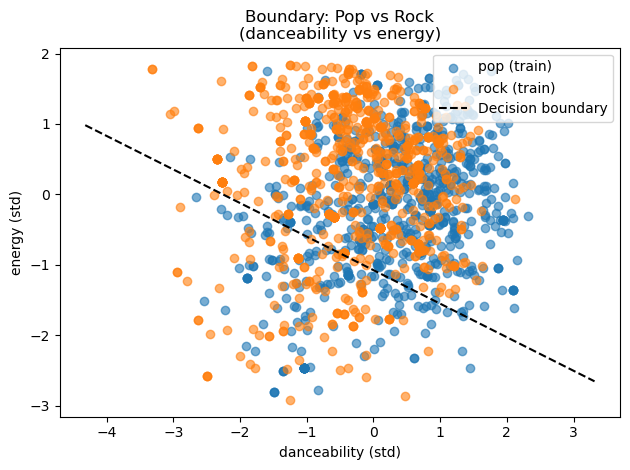

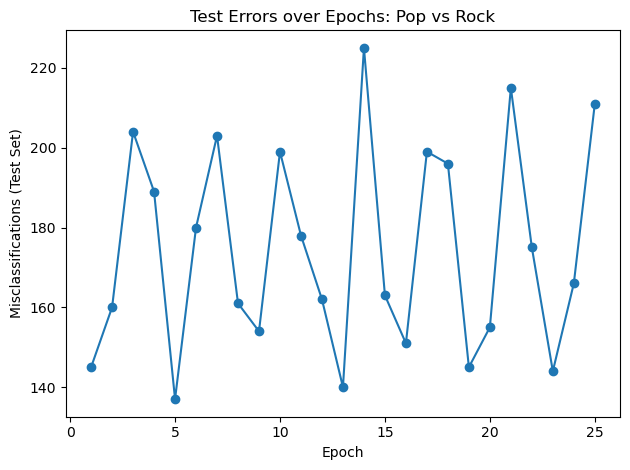

Epoch 1: train errs = 801, test errs = 190
Epoch 2: train errs = 756, test errs = 154
Epoch 3: train errs = 609, test errs = 196
Epoch 4: train errs = 783, test errs = 199
Epoch 5: train errs = 801, test errs = 160
Epoch 6: train errs = 606, test errs = 165
Epoch 7: train errs = 633, test errs = 202
Epoch 8: train errs = 810, test errs = 199
Epoch 9: train errs = 801, test errs = 178
Epoch 10: train errs = 685, test errs = 168
Epoch 11: train errs = 656, test errs = 202
Epoch 12: train errs = 796, test errs = 196
Epoch 13: train errs = 785, test errs = 174
Epoch 14: train errs = 654, test errs = 171
Epoch 15: train errs = 648, test errs = 212
Epoch 16: train errs = 879, test errs = 183
Epoch 17: train errs = 691, test errs = 158
Epoch 18: train errs = 603, test errs = 215
Epoch 19: train errs = 870, test errs = 181
Epoch 20: train errs = 695, test errs = 158
Epoch 21: train errs = 597, test errs = 231
Epoch 22: train errs = 983, test errs = 158
Epoch 23: train errs = 608, test errs = 1

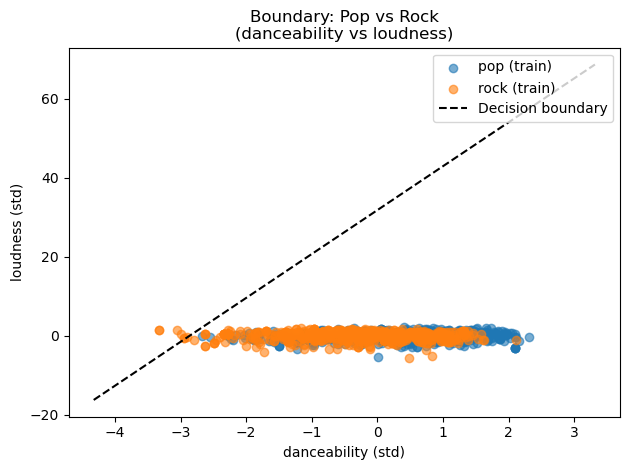

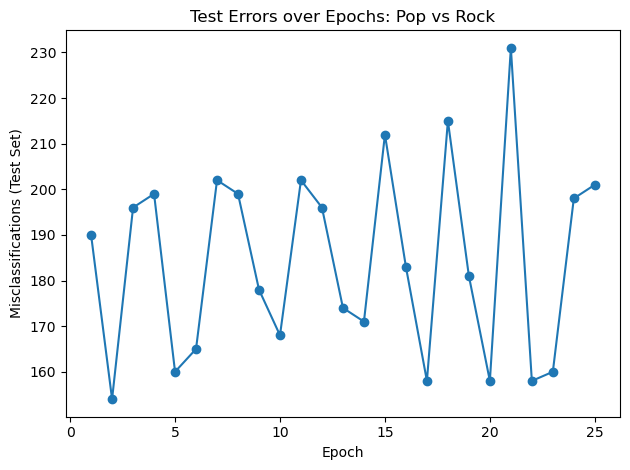

Epoch 1: train errs = 801, test errs = 201
Epoch 2: train errs = 799, test errs = 180
Epoch 3: train errs = 747, test errs = 210
Epoch 4: train errs = 852, test errs = 169
Epoch 5: train errs = 700, test errs = 200
Epoch 6: train errs = 840, test errs = 181
Epoch 7: train errs = 727, test errs = 148
Epoch 8: train errs = 663, test errs = 198
Epoch 9: train errs = 764, test errs = 232
Epoch 10: train errs = 933, test errs = 165
Epoch 11: train errs = 684, test errs = 206
Epoch 12: train errs = 851, test errs = 176
Epoch 13: train errs = 713, test errs = 159
Epoch 14: train errs = 668, test errs = 191
Epoch 15: train errs = 760, test errs = 204
Epoch 16: train errs = 834, test errs = 165
Epoch 17: train errs = 684, test errs = 213
Epoch 18: train errs = 849, test errs = 176
Epoch 19: train errs = 703, test errs = 186
Epoch 20: train errs = 770, test errs = 187
Epoch 21: train errs = 767, test errs = 215
Epoch 22: train errs = 867, test errs = 177
Epoch 23: train errs = 701, test errs = 1

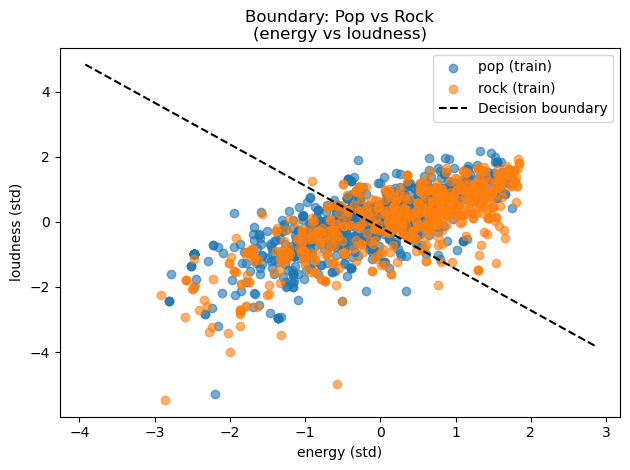

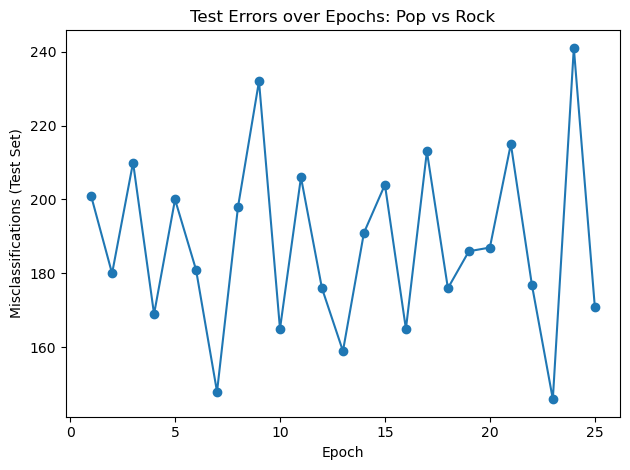

Epoch 1: train errs = 1060, test errs = 106
Epoch 2: train errs = 477, test errs = 113
Epoch 3: train errs = 487, test errs = 114
Epoch 4: train errs = 486, test errs = 290
Epoch 5: train errs = 1129, test errs = 107
Epoch 6: train errs = 487, test errs = 108
Epoch 7: train errs = 485, test errs = 110
Epoch 8: train errs = 473, test errs = 299
Epoch 9: train errs = 1151, test errs = 105
Epoch 10: train errs = 459, test errs = 103
Epoch 11: train errs = 464, test errs = 113
Epoch 12: train errs = 486, test errs = 118
Epoch 13: train errs = 508, test errs = 285
Epoch 14: train errs = 1092, test errs = 111
Epoch 15: train errs = 478, test errs = 111
Epoch 16: train errs = 476, test errs = 118
Epoch 17: train errs = 505, test errs = 279
Epoch 18: train errs = 1064, test errs = 117
Epoch 19: train errs = 500, test errs = 119
Epoch 20: train errs = 496, test errs = 118
Epoch 21: train errs = 500, test errs = 117
Epoch 22: train errs = 488, test errs = 290
Epoch 23: train errs = 1130, test er

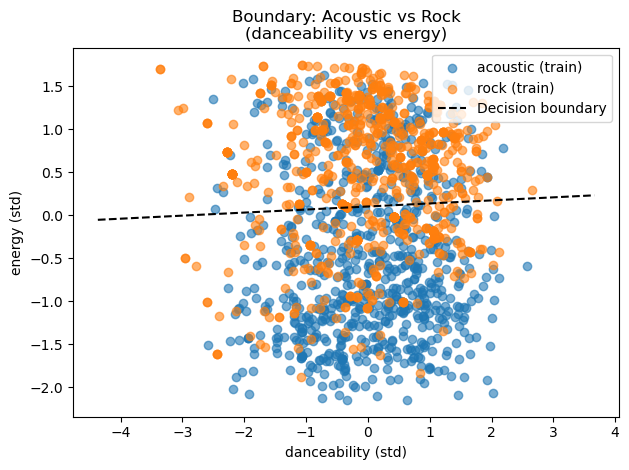

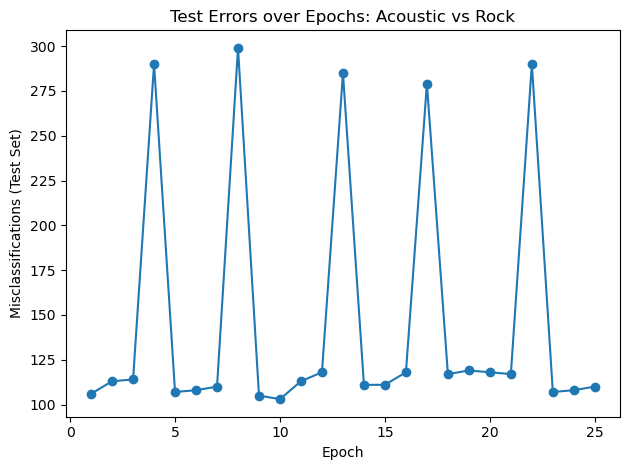

Epoch 1: train errs = 814, test errs = 156
Epoch 2: train errs = 642, test errs = 132
Epoch 3: train errs = 584, test errs = 182
Epoch 4: train errs = 760, test errs = 201
Epoch 5: train errs = 799, test errs = 135
Epoch 6: train errs = 549, test errs = 133
Epoch 7: train errs = 584, test errs = 192
Epoch 8: train errs = 741, test errs = 182
Epoch 9: train errs = 752, test errs = 138
Epoch 10: train errs = 609, test errs = 161
Epoch 11: train errs = 664, test errs = 160
Epoch 12: train errs = 693, test errs = 190
Epoch 13: train errs = 764, test errs = 154
Epoch 14: train errs = 657, test errs = 127
Epoch 15: train errs = 568, test errs = 164
Epoch 16: train errs = 609, test errs = 196
Epoch 17: train errs = 835, test errs = 147
Epoch 18: train errs = 584, test errs = 175
Epoch 19: train errs = 720, test errs = 161
Epoch 20: train errs = 693, test errs = 133
Epoch 21: train errs = 591, test errs = 154
Epoch 22: train errs = 645, test errs = 201
Epoch 23: train errs = 799, test errs = 1

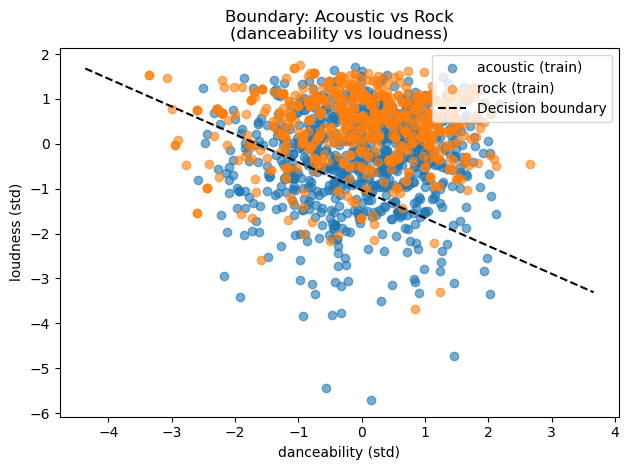

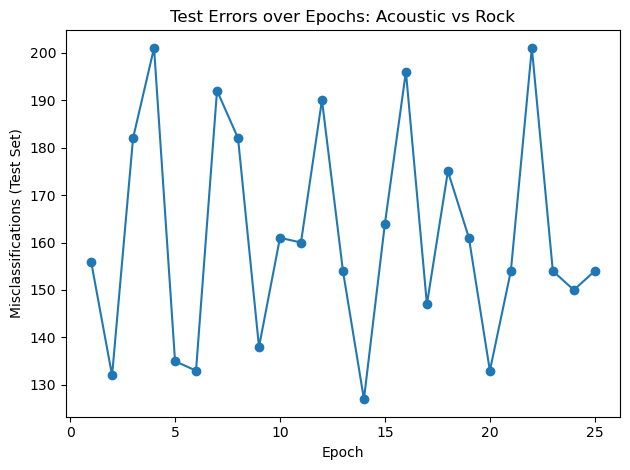

Epoch 1: train errs = 572, test errs = 290
Epoch 2: train errs = 1111, test errs = 113
Epoch 3: train errs = 490, test errs = 112
Epoch 4: train errs = 486, test errs = 110
Epoch 5: train errs = 472, test errs = 258
Epoch 6: train errs = 988, test errs = 103
Epoch 7: train errs = 458, test errs = 96
Epoch 8: train errs = 442, test errs = 111
Epoch 9: train errs = 479, test errs = 271
Epoch 10: train errs = 1087, test errs = 106
Epoch 11: train errs = 480, test errs = 103
Epoch 12: train errs = 471, test errs = 112
Epoch 13: train errs = 482, test errs = 210
Epoch 14: train errs = 826, test errs = 131
Epoch 15: train errs = 517, test errs = 108
Epoch 16: train errs = 465, test errs = 118
Epoch 17: train errs = 530, test errs = 291
Epoch 18: train errs = 1081, test errs = 111
Epoch 19: train errs = 486, test errs = 109
Epoch 20: train errs = 477, test errs = 107
Epoch 21: train errs = 479, test errs = 261
Epoch 22: train errs = 1048, test errs = 97
Epoch 23: train errs = 450, test errs =

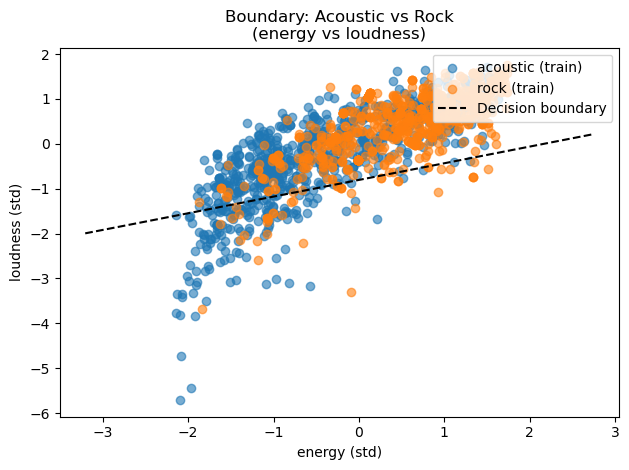

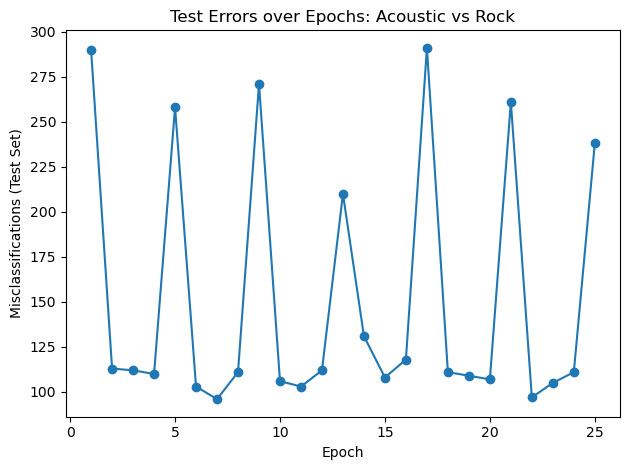

In [89]:
# ## Run on Three Feature-Pairs

#%% [code]
feature_pairs = [
    ('danceability','energy'),
    ('danceability','loudness'),
    ('energy','loudness')
]

# Pop vs Rock
for fx, fy in feature_pairs:
    run_experiment(['pop','rock'], fx, fy, lr=0.01, epochs=25)

# Acoustic vs Rock
for fx, fy in feature_pairs:
    run_experiment(['acoustic','rock'], fx, fy, lr=0.01, epochs=25)